# PHẦN 0: THIẾT LẬP MÔI TRƯỜNG VÀ CÁC HẰNG SỐ


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PHẦN 0: THIẾT LẬP MÔI TRƯỜNG


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import xgboost as xgb

In [ ]:
# Cấu hình
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
print("Hoàn thành thiết lập.")

Hoàn thành thiết lập.


# PHẦN 1: TẢI VÀ FEATURE ENGINEERING

In [ ]:
# Đọc các file CSV thành DataFrame
path = "/content/drive/MyDrive/ML"
try:
    df_objects = pd.read_csv(os.path.join(path, 'objects.csv'), low_memory=False)
    df_funding_rounds = pd.read_csv(os.path.join(path, 'funding_rounds.csv'))
    df_ipos = pd.read_csv(os.path.join(path, 'ipos.csv'))
    df_acquisitions = pd.read_csv(os.path.join(path, 'acquisitions.csv'))
    df_relationships = pd.read_csv(os.path.join(path, 'relationships.csv'))
    df_milestones = pd.read_csv(os.path.join(path, 'milestones.csv'))
    df_investments = pd.read_csv(os.path.join(path, 'investments.csv'))
    df_funds = pd.read_csv(os.path.join(path, 'funds.csv'))
    df_degrees = pd.read_csv(os.path.join(path, 'degrees.csv'))
    print("Tải dữ liệu thành công.")
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file {e.filename}. Vui lòng kiểm tra lại đường dẫn.")
    exit()

Tải dữ liệu thành công.


In [ ]:
# Lọc các công ty từ bảng objects
df_companies = df_objects[df_objects['entity_type'] == 'Company'].copy()

# Tạo danh sách các công ty đã IPO và đã bị mua lại (acquired)
ipo_ids = set(df_ipos['object_id'])
acquired_ids = set(df_acquisitions['acquired_object_id'])
successful_ids = ipo_ids.union(acquired_ids)

# Thêm cột 'is_successful' xác định công ty thành công (IPO hoặc acquired)
df_companies['is_successful'] = df_companies['id'].isin(successful_ids).astype(int)

# Chuyển đổi kiểu dữ liệu ngày tháng
df_companies['founded_at'] = pd.to_datetime(df_companies['founded_at'], errors='coerce')
df_funding_rounds['funded_at'] = pd.to_datetime(df_funding_rounds['funded_at'], errors='coerce')
df_milestones['milestone_at'] = pd.to_datetime(df_milestones['milestone_at'], errors='coerce')

# Tổng hợp dữ liệu funding cho từng công ty
funding_agg = df_funding_rounds.groupby('object_id').agg(
    total_funding_usd=('raised_amount_usd', 'sum'),
    num_funding_rounds=('id', 'count'),
    first_funding_at=('funded_at', 'min'),
    last_funding_at=('funded_at', 'max')
).reset_index()

# Tổng hợp dữ liệu milestone cho từng công ty
milestone_agg = df_milestones.groupby('object_id').agg(
    num_milestones=('id', 'count'),
    first_milestone_at=('milestone_at', 'min'),
    last_milestone_at=('milestone_at', 'max')
).reset_index()

# Tìm những relationship là founder
df_founders = df_relationships[df_relationships['title'].str.contains('founder', case=False, na=False)].copy()

# Đếm số lượng founder cho mỗi công ty
founder_counts = df_founders.groupby('relationship_object_id').size().reset_index(name='num_founders')

# Đếm team size cho mỗi công ty
team_size = df_relationships.groupby('relationship_object_id').size().reset_index(name='team_size')

# Tạo bảng tổng hợp cuối cùng
df_final = df_companies[['id', 'category_code', 'founded_at', 'is_successful']].copy()
df_final = pd.merge(df_final, funding_agg, left_on='id', right_on='object_id', how='left')
df_final = pd.merge(df_final, milestone_agg, left_on='id', right_on='object_id', how='left')
df_final = pd.merge(df_final, founder_counts, left_on='id', right_on='relationship_object_id', how='left')
df_final = pd.merge(df_final, team_size, left_on='id', right_on='relationship_object_id', how='left')

# Loại bỏ các cột phụ không cần thiết
df_final.drop(
    columns=[col for col in df_final.columns if 'object_id' in str(col) or 'relationship_object_id' in str(col)],
    inplace=True
)


In [ ]:
# Đếm số công ty mỗi người đã sáng lập
founder_experience = df_founders.groupby('person_object_id')['relationship_object_id'].count().reset_index()
founder_experience.rename(columns={'relationship_object_id': 'founder_num_companies'}, inplace=True)

# Lấy thông tin founder cho mỗi công ty
company_founders = df_relationships[df_relationships['title'].str.contains('founder', case=False, na=False)][['relationship_object_id', 'person_object_id']]
# Gộp kinh nghiệm của founder vào
company_founders = pd.merge(company_founders, founder_experience, on='person_object_id', how='left')
# Tính trung bình kinh nghiệm của các founder trong một công ty
avg_founder_exp = company_founders.groupby('relationship_object_id')['founder_num_companies'].mean().reset_index()
avg_founder_exp.rename(columns={'founder_num_companies': 'avg_founder_experience'}, inplace=True)

df_final = pd.merge(df_final, avg_founder_exp, left_on='id', right_on='relationship_object_id', how='left')
df_final.drop(columns=['relationship_object_id'], inplace=True)

# Cờ cho founder có bằng cấp từ trường Top
TOP_UNIVERSITIES = ['Stanford University', 'Harvard University', 'MIT', 'University of Cambridge', 'University of California, Berkeley']
df_degrees['is_top_school'] = df_degrees['institution'].isin(TOP_UNIVERSITIES).astype(int)
founder_education = df_degrees[df_degrees['is_top_school'] == 1].groupby('object_id')['is_top_school'].max().reset_index() # object_id ở đây là person_id
founder_education.rename(columns={'object_id': 'person_object_id'}, inplace=True)

company_founders_edu = pd.merge(company_founders, founder_education, on='person_object_id', how='left')
company_top_school_founders = company_founders_edu.groupby('relationship_object_id')['is_top_school'].sum().reset_index()
company_top_school_founders.rename(columns={'is_top_school': 'num_founders_top_school'}, inplace=True)

df_final = pd.merge(df_final, company_top_school_founders, left_on='id', right_on='relationship_object_id', how='left')
df_final.drop(columns=['relationship_object_id'], inplace=True)

# Đếm số nhà đầu tư top-tier
TOP_TIER_VCS = ['f:2', 'f:3', 'f:4', 'f:5', 'f:6', 'f:7', 'f:8', 'f:17'] # Ví dụ: Sequoia, Accel, etc.
df_investments['is_top_tier_vc'] = df_investments['investor_object_id'].isin(TOP_TIER_VCS).astype(int)
top_tier_investments = df_investments[df_investments['is_top_tier_vc'] == 1]
num_top_tier_investors = top_tier_investments.groupby('funded_object_id')['investor_object_id'].nunique().reset_index()
num_top_tier_investors.rename(columns={'investor_object_id': 'num_top_tier_investors'}, inplace=True)

df_final = pd.merge(df_final, num_top_tier_investors, left_on='id', right_on='funded_object_id', how='left')
df_final.drop(columns=['funded_object_id'], inplace=True)

# Tính tổng số vốn các nhà đầu tư đã huy động được
investor_fund_size = df_funds.groupby('object_id')['raised_amount'].sum().reset_index() # object_id ở đây là fund_id
investor_fund_size.rename(columns={'object_id': 'investor_object_id', 'raised_amount': 'investor_total_raised'}, inplace=True)

company_investments = pd.merge(df_investments, investor_fund_size, on='investor_object_id', how='left')
total_investor_power = company_investments.groupby('funded_object_id')['investor_total_raised'].sum().reset_index()
total_investor_power.rename(columns={'investor_total_raised': 'total_investor_fund_power'}, inplace=True)

df_final = pd.merge(df_final, total_investor_power, left_on='id', right_on='funded_object_id', how='left')
df_final.drop(columns=['funded_object_id'], inplace=True)

In [ ]:
# Đặt mốc thời gian snapshot (thời điểm chụp dữ liệu)
snapshot_date = pd.to_datetime('2013-12-31')

# Tạo các đặc trưng mới liên quan đến thời gian và hiệu suất công ty
df_final['company_age_years'] = (snapshot_date - df_final['founded_at']).dt.days / 365.25
df_final['time_since_last_funding'] = (snapshot_date - df_final['last_funding_at']).dt.days / 365.25
df_final['time_to_first_funding'] = (df_final['first_funding_at'] - df_final['founded_at']).dt.days / 365.25
df_final['funding_duration_years'] = (df_final['last_funding_at'] - df_final['first_funding_at']).dt.days / 365.25
df_final['funding_velocity_usd_per_year'] = df_final['total_funding_usd'] / (df_final['company_age_years'] + 1e-6)
df_final['milestones_per_year'] = df_final['num_milestones'] / (df_final['company_age_years'] + 1e-6)

# Lựa chọn các cột đặc trưng để đưa vào model
final_features = [
    'is_successful', 'category_code', 'company_age_years', 'total_funding_usd',
    'num_funding_rounds', 'time_since_last_funding', 'time_to_first_funding',
    'funding_duration_years', 'funding_velocity_usd_per_year', 'num_milestones',
    'milestones_per_year', 'num_founders', 'team_size',
    'avg_founder_experience', 'num_founders_top_school',
    'num_top_tier_investors', 'total_investor_fund_power'
]

df_model = df_final[final_features].copy()

# Xử lý missing values cho các cột số: điền 0 cho các trường hợp không có dữ liệu
cols_to_fill_zero = [
    'total_funding_usd', 'num_funding_rounds', 'num_milestones',
    'num_founders', 'team_size', 'funding_velocity_usd_per_year',
    'milestones_per_year',
    'avg_founder_experience', 'num_founders_top_school',
    'num_top_tier_investors', 'total_investor_fund_power'
]
for col in cols_to_fill_zero:
    df_model[col].fillna(0, inplace=True)

# Với các cột thời gian không có funding thì điền giá trị lớn (99 năm) để biểu thị 'không từng có'
for col in ['time_since_last_funding', 'time_to_first_funding', 'funding_duration_years']:
    df_model[col].fillna(99, inplace=True)

# Tuổi công ty thiếu thì điền giá trị trung vị
df_model['company_age_years'].fillna(df_model['company_age_years'].median(), inplace=True)

# Danh mục ngành (category_code) thiếu thì điền 'missing'
df_model['category_code'].fillna('missing', inplace=True)

print("Hoàn thành Feature Engineering.")



Hoàn thành Feature Engineering.


In [ ]:
df_model.describe()

,is_successful,company_age_years,total_funding_usd,num_funding_rounds,time_since_last_funding,time_to_first_funding,funding_duration_years,funding_velocity_usd_per_year,num_milestones,milestones_per_year,num_founders,team_size,avg_founder_experience,num_founders_top_school,num_top_tier_investors,total_investor_fund_power
count,196553.000000,196553.000000,1.965530e+05,196553.000000,196553.000000,196553.000000,196553.000000,1.965530e+05,196553.000000,196553.000000,196553.000000,196553.000000,196553.000000,196553.000000,196553.000000,1.965530e+05
mean,0.053563,6.402290,2.101193e+06,0.267745,83.566491,87.202639,83.264438,2.462400e+05,0.145060,0.028153,0.347779,1.858394,0.367292,0.014078,0.005383,1.505092e+08
std,0.225154,6.906583,2.603485e+07,0.778228,35.338540,31.490989,36.021298,6.601079e+06,0.960413,1.676857,0.752612,7.451277,0.876864,0.133215,0.078276,1.489866e+09
min,0.000000,-0.750171,0.000000e+00,0.000000,0.052019,-48.010951,0.000000,-2.557684e+07,0.000000,-730.766913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,4.996578,0.000000e+00,0.000000,99.000000,99.000000,99.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,4.996578,0.000000e+00,0.000000,99.000000,99.000000,99.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,4.996578,0.000000e+00,0.000000,99.000000,99.000000,99.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00
max,1.000000,112.996578,5.700000e+09,15.000000,99.000000,106.622861,99.000000,2.575457e+09,65.000000,52.177891,26.000000,1178.000000,21.000000,6.000000,4.000000,8.051000e+10


# PHẦN 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)


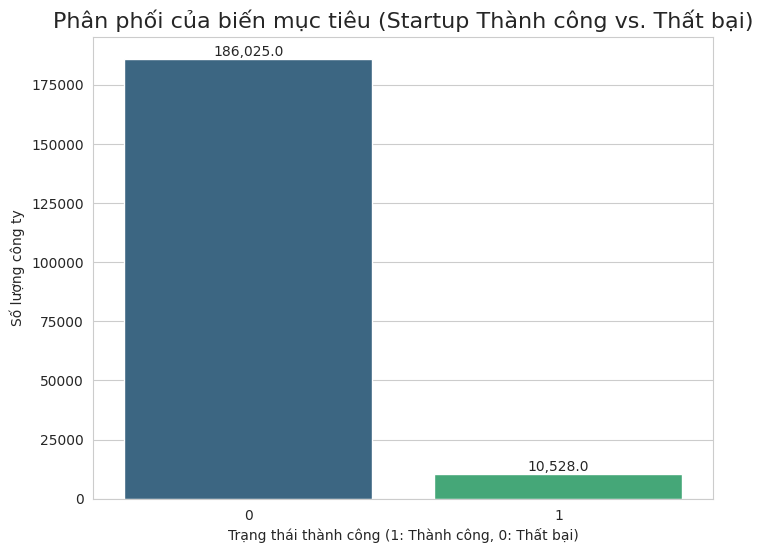

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_successful', data=df_model,palette='viridis')
plt.title('Phân phối của biến mục tiêu (Startup Thành công vs. Thất bại)', fontsize=16)
plt.xlabel('Trạng thái thành công (1: Thành công, 0: Thất bại)')
plt.ylabel('Số lượng công ty')
# Ghi chú số lượng trên từng cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

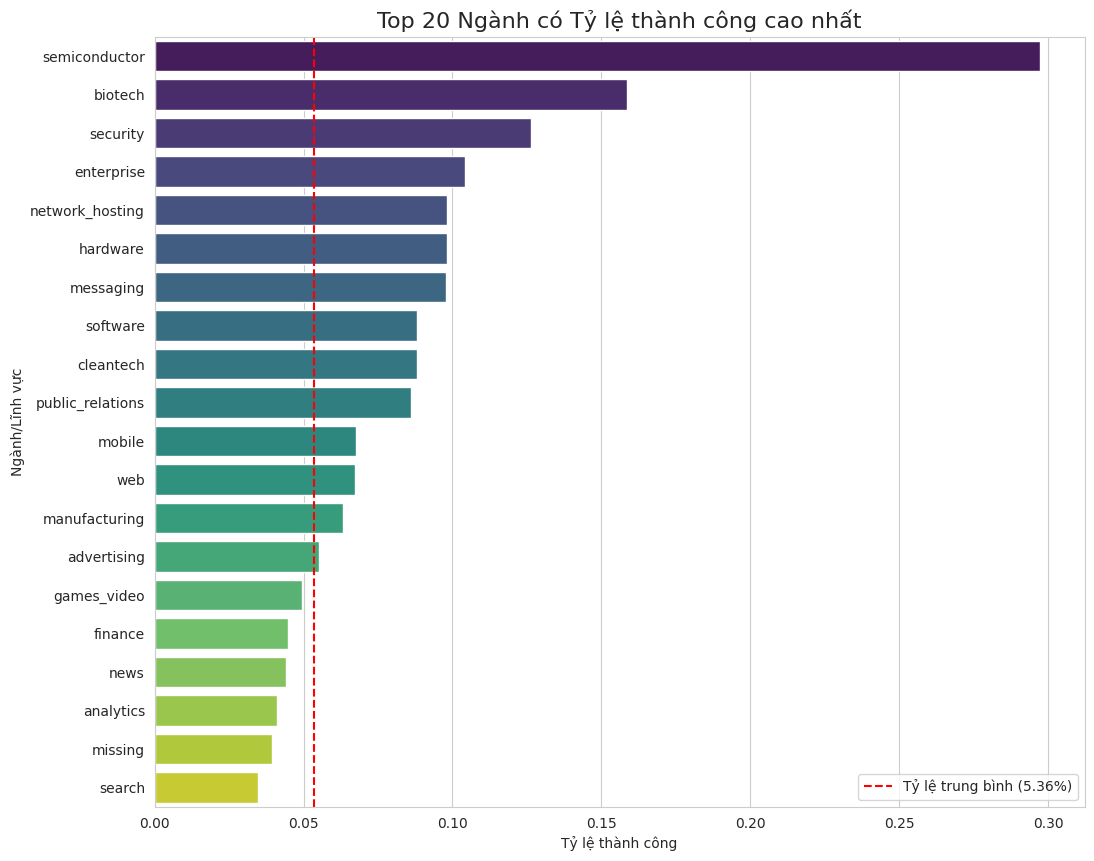

In [ ]:
# Phân tích tỷ lệ thành công theo ngành
category_success_eda = df_model.groupby('category_code')['is_successful'].agg(['mean', 'count']).rename(columns={'mean': 'success_rate', 'count': 'company_count'})

top_20_successful_cats = category_success_eda[category_success_eda['company_count'] > 50].sort_values(by='success_rate', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(y=top_20_successful_cats.index, x=top_20_successful_cats['success_rate'], palette='viridis')
plt.title('Top 20 Ngành có Tỷ lệ thành công cao nhất', fontsize=16)
plt.xlabel('Tỷ lệ thành công')
plt.ylabel('Ngành/Lĩnh vực')
plt.axvline(x=df_model['is_successful'].mean(), color='r', linestyle='--', label=f'Tỷ lệ trung bình ({df_model["is_successful"].mean():.2%})')
plt.legend()
plt.show()

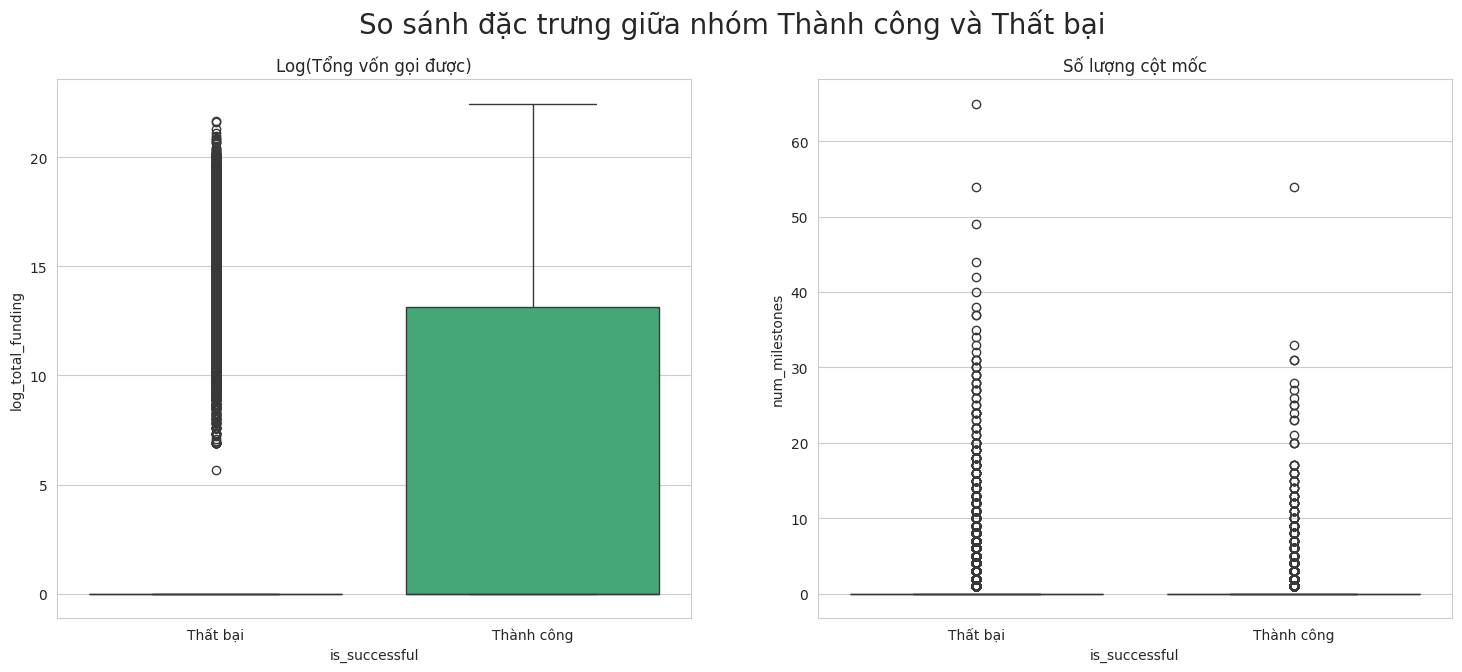

In [ ]:
df_eda = df_model.copy()

df_eda['log_total_funding'] = np.log1p(df_eda['total_funding_usd'])
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('So sánh đặc trưng giữa nhóm Thành công và Thất bại', fontsize=20)
sns.boxplot(x='is_successful', y='log_total_funding', data=df_eda, ax=axes[0], palette='viridis')
axes[0].set_title('Log(Tổng vốn gọi được)')
axes[0].set_xticklabels(['Thất bại', 'Thành công'])
sns.boxplot(x='is_successful', y='num_milestones', data=df_eda, ax=axes[1], palette = 'viridis')
axes[1].set_title('Số lượng cột mốc')
axes[1].set_xticklabels(['Thất bại', 'Thành công'])
plt.show()

# PHẦN 3: CHUẨN BỊ DỮ LIỆU VÀ HUẤN LUYỆN MÔ HÌNH

In [ ]:
# 3.1. Xác định các nhóm đặc trưng
# Đặc trưng cho phần "Wide" (các tương tác đơn giản, dễ nhớ)
# Dùng các đặc trưng one-hot cho phần này

df_wide = pd.get_dummies(df_model[['category_code']], prefix='cat', drop_first=True)
wide_cols = df_wide.columns.tolist()

# Đặc trưng cho phần "Deep"
# Dữ liệu phân loại cho Embedding

encoder = LabelEncoder()
df_deep_cat = pd.DataFrame()
df_deep_cat['category_code_encoded'] = encoder.fit_transform(df_model['category_code'])
num_categories = len(encoder.classes_)
deep_cat_cols = ['category_code_encoded']

# Dữ liệu số
deep_num_cols = [col for col in df_model.columns if col not in ['is_successful', 'category_code']]

In [ ]:
# 3.2. Tách và Chuẩn hóa
X_wide = df_wide
X_deep_cat = df_deep_cat
X_deep_num = df_model[deep_num_cols]
y = df_model['is_successful']

# Chia dữ liệu, đảm bảo tất cả các phần được căn chỉnh
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('is_successful', axis=1), y, test_size=0.2, random_state=42, stratify=y)

X_train_wide = X_wide.loc[X_train.index]
X_test_wide = X_wide.loc[X_test.index]

X_train_deep_cat = X_deep_cat.loc[X_train.index]
X_test_deep_cat = X_deep_cat.loc[X_test.index]

X_train_deep_num = X_deep_num.loc[X_train.index]
X_test_deep_num = X_deep_num.loc[X_test.index]

scaler = StandardScaler()
X_train_deep_num_scaled = scaler.fit_transform(X_train_deep_num)
X_test_deep_num_scaled = scaler.transform(X_test_deep_num)
print("Hoàn thành chuẩn bị dữ liệu cho 3 luồng input.")

Hoàn thành chuẩn bị dữ liệu cho 3 luồng input.


# PHẦN 4: XÂY DỰNG MÔ HÌNH WIDE & DEEP VỚI EMBEDDING


In [ ]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

# --- Input Layers ---
input_wide = Input(shape=(len(wide_cols),), name='input_wide')
input_deep_num = Input(shape=(len(deep_num_cols),), name='input_deep_numeric')
input_deep_cat = Input(shape=(1,), name='input_deep_categorical')

# --- Deep Path ---
embedding_size = 10
embedding_layer = Embedding(input_dim=num_categories, output_dim=embedding_size, name='category_embedding')(input_deep_cat)
embedding_flat = Flatten()(embedding_layer)
deep_path_concat = Concatenate()([input_deep_num, embedding_flat])
deep_path = Dense(128, activation='relu')(deep_path_concat)
deep_path = BatchNormalization()(deep_path)
deep_path = Dropout(0.5)(deep_path)
deep_path = Dense(64, activation='relu')(deep_path)
deep_path = BatchNormalization()(deep_path)
deep_path = Dropout(0.4)(deep_path)

# --- Wide & Deep Combination ---
final_concat = Concatenate()([input_wide, deep_path])
output = Dense(1, activation='sigmoid')(final_concat)

# --- Build and Compile Model ---
model = Model(inputs=[input_wide, input_deep_num, input_deep_cat], outputs=output)
model.compile(optimizer='adam', loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
plot_model(model, show_shapes=True, show_layer_names=True)
plt.show()

# PHẦN 5: HUẤN LUYỆN VÀ ĐÁNH GIÁ


In [ ]:
print("\n--- PHẦN 5: HUẤN LUYỆN VÀ ĐÁNH GIÁ ---")
X_train_inputs = [X_train_wide, X_train_deep_num_scaled, X_train_deep_cat]
X_test_inputs = [X_test_wide, X_test_deep_num_scaled, X_test_deep_cat]
early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True, verbose=0)
print("Đang huấn luyện mô hình...")
history = model.fit(
    X_train_inputs, y_train,
    validation_data=(X_test_inputs, y_test),
    epochs=200, batch_size=128,
    callbacks=[early_stopping], verbose=0
)
print("Hoàn thành huấn luyện.")


--- PHẦN 5: HUẤN LUYỆN VÀ ĐÁNH GIÁ ---
Đang huấn luyện mô hình...
Hoàn thành huấn luyện.


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


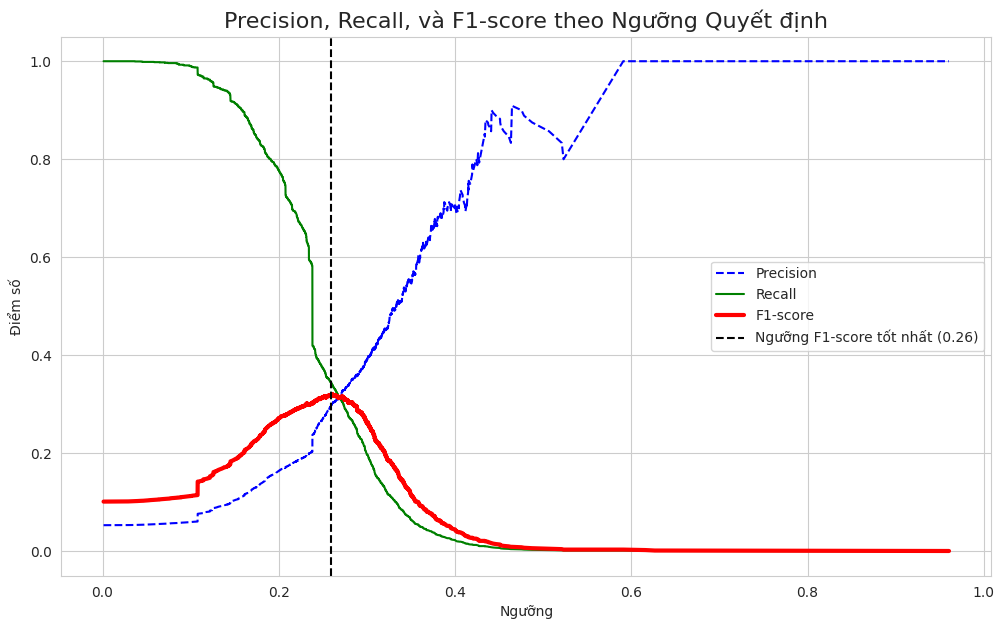

In [ ]:
y_pred_proba = model.predict(X_test_inputs).flatten()
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (recalls * precisions) / (recalls + precisions + 1e-9)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.99

plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-score", lw=3)
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Ngưỡng F1-score tốt nhất ({best_threshold:.2f})')
plt.title('Precision, Recall, và F1-score theo Ngưỡng Quyết định', fontsize=16)
plt.xlabel('Ngưỡng')
plt.ylabel('Điểm số')
plt.legend()
plt.grid(True)
plt.show()


Báo cáo phân loại cuối cùng với ngưỡng tối ưu:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     37205
           1       0.30      0.34      0.32      2106

    accuracy                           0.92     39311
   macro avg       0.63      0.65      0.64     39311
weighted avg       0.93      0.92      0.92     39311



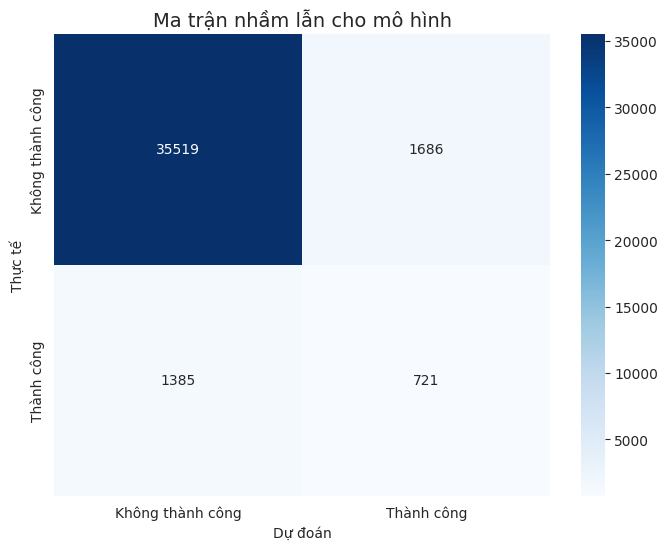

In [ ]:
y_pred_class_optimal = (y_pred_proba > best_threshold).astype(int)
print("\nBáo cáo phân loại cuối cùng với ngưỡng tối ưu:")
print(classification_report(y_test, y_pred_class_optimal))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_class_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không thành công', 'Thành công'],
            yticklabels=['Không thành công', 'Thành công'])
plt.title(f'Ma trận nhầm lẫn cho mô hình', fontsize=14)
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

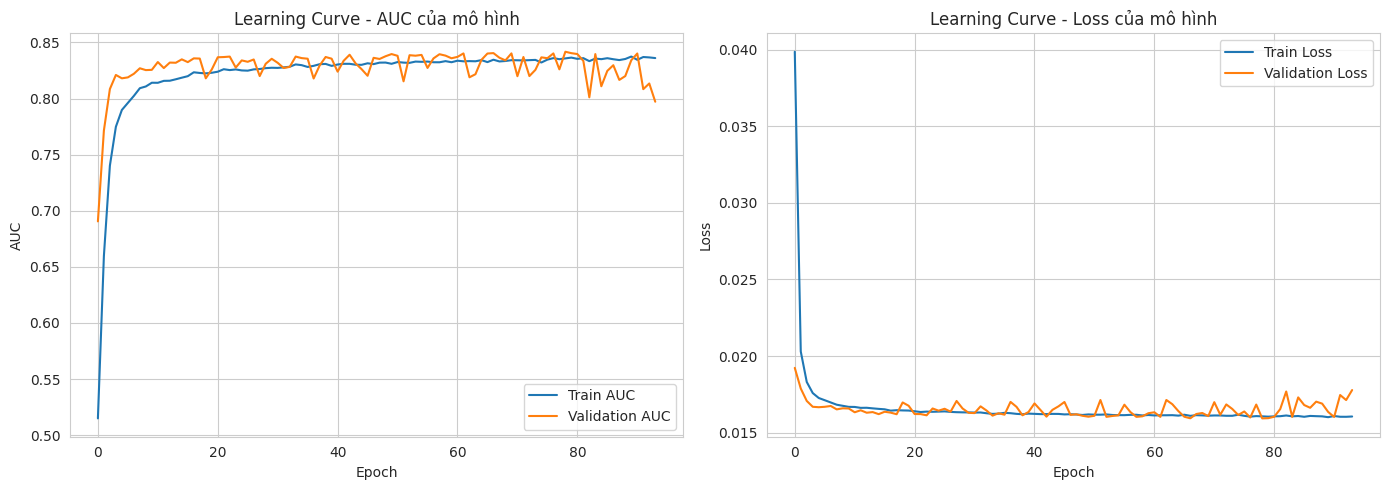

In [ ]:
plt.figure(figsize=(14, 5))

# Đồ thị AUC
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title(f'Learning Curve - AUC của mô hình')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Đồ thị Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss của mô hình')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# TÍCH HỢP: PHẦN 5B - HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH BASELINE (XGBOOST)

In [ ]:
# 1. Chuẩn bị dữ liệu cho XGBoost
# Dữ liệu số đã được chuẩn hóa, ta chỉ cần one-hot encode category_code
X_train_xgb = pd.concat([pd.DataFrame(X_train_deep_num_scaled, index=X_train.index), X_train_wide], axis=1)
X_test_xgb = pd.concat([pd.DataFrame(X_test_deep_num_scaled, index=X_test.index), X_test_wide], axis=1)

In [ ]:
# 2. Huấn luyện mô hình
# Xử lý mất cân bằng dữ liệu cho XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

print("Đang huấn luyện mô hình XGBoost...")
xgb_model.fit(X_train_xgb, y_train)
print("Hoàn thành huấn luyện XGBoost.")


Đang huấn luyện mô hình XGBoost...
Hoàn thành huấn luyện XGBoost.



Báo cáo phân loại cho mô hình XGBoost:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     37205
           1       0.17      0.76      0.27      2106

    accuracy                           0.78     39311
   macro avg       0.57      0.77      0.57     39311
weighted avg       0.94      0.78      0.84     39311

Ma trận nhầm lẫn cho XGBoost:


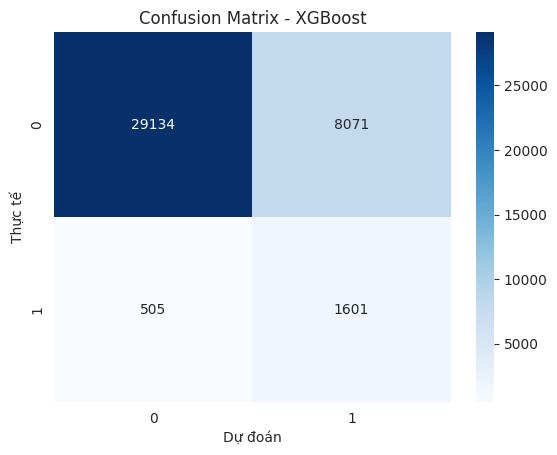

In [ ]:
# 3. Đánh giá mô hình
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print("\nBáo cáo phân loại cho mô hình XGBoost:")
print(classification_report(y_test, y_pred_xgb))

print("Ma trận nhầm lẫn cho XGBoost:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# PHẦN 6: ỨNG DỤNG CHO VINACAPITAL VENTURES (VCV)


## ***6.1. Ý tưởng 1: Phễu sàng lọc Deal thông minh***

In [ ]:
# 1. Tạo DataFrame kết quả, xếp hạng theo điểm tiềm năng
df_eval = pd.DataFrame({
    'startup_index': y_test.index,
    'y_true': y_test,
    'potential_score': y_pred_proba
}).sort_values(by='potential_score', ascending=False).reset_index(drop=True)

print(f"Tổng số startup trong tập test (đầu phễu): {len(df_eval):,}")

# 2. Định nghĩa các tầng của phễu
total_startups = len(df_eval)
tiers = {
    "Tier A: Ưu tiên cao nhất": 0.05,  # Top 5%
    "Tier B: Đáng xem xét": 0.10,      # Top 10% (không bao gồm 5% đầu)
    "Tier C: Tiềm năng thấp": 0.20,   # Top 20% (không bao gồm 10% đầu)
    "Tier D: Sàng lọc tự động": 1.00   # Phần còn lại
}

# 3. Phân tích từng tầng của phễu
results = []
total_successes = df_eval['y_true'].sum()
last_cutoff = 0

for tier_name, tier_percentage in tiers.items():
    # Xác định các startup trong tầng này
    current_cutoff = int(total_startups * tier_percentage)
    tier_df = df_eval.iloc[last_cutoff:current_cutoff]

    # Tính toán các chỉ số
    num_startups_in_tier = len(tier_df)
    num_successes_in_tier = tier_df['y_true'].sum()
    # Tỷ lệ "trúng" trong tầng này là bao nhiêu?
    hit_rate = (num_successes_in_tier / num_startups_in_tier) if num_startups_in_tier > 0 else 0

    results.append({
        "Tầng (Tier)": tier_name,
        "Số lượng Startup": f"{num_startups_in_tier:,}",
        "Số Startup thành công tìm được": num_successes_in_tier,
        "Tỷ lệ 'trúng' (Hit Rate)": f"{hit_rate:.2%}"
    })

    last_cutoff = current_cutoff

df_funnel_report = pd.DataFrame(results)

print("\nBÁO CÁO PHÂN TÍCH PHỄU SÀNG LỌC:")
print(df_funnel_report.to_string())

# Tính toán Recall@K% để bổ sung
recall_at_5_percent = df_funnel_report.loc[0, "Số Startup thành công tìm được"] / total_successes
recall_at_10_percent = df_funnel_report.loc[:1, "Số Startup thành công tìm được"].sum() / total_successes
recall_at_20_percent = df_funnel_report.loc[:2, "Số Startup thành công tìm được"].sum() / total_successes

print("\nPHÂN TÍCH HIỆU QUẢ:")
print(f"- Nếu chỉ thẩm định Tier A (Top 5%), VCV sẽ xem xét {df_funnel_report.loc[0, 'Số lượng Startup']} startup và có khả năng tìm thấy {recall_at_5_percent:.2%} tổng số các startup thành công.")
print(f"- Nếu thẩm định Tier A+B (Top 10%), VCV sẽ xem xét {int(total_startups*0.1):,} startup và có khả năng tìm thấy {recall_at_10_percent:.2%} tổng số các startup thành công.")
print(f"- Nếu thẩm định Tier A+B+C (Top 20%), VCV sẽ xem xét {int(total_startups*0.2):,} startup và có khả năng tìm thấy {recall_at_20_percent:.2%} tổng số các startup thành công.")

Tổng số startup trong tập test (đầu phễu): 39,311

BÁO CÁO PHÂN TÍCH PHỄU SÀNG LỌC:
                Tầng (Tier) Số lượng Startup  Số Startup thành công tìm được Tỷ lệ 'trúng' (Hit Rate)
0  Tier A: Ưu tiên cao nhất            1,965                             642                   32.67%
1      Tier B: Đáng xem xét            1,966                             280                   14.24%
2    Tier C: Tiềm năng thấp            3,931                             525                   13.36%
3  Tier D: Sàng lọc tự động           31,449                             659                    2.10%

PHÂN TÍCH HIỆU QUẢ:
- Nếu chỉ thẩm định Tier A (Top 5%), VCV sẽ xem xét 1,965 startup và có khả năng tìm thấy 30.48% tổng số các startup thành công.
- Nếu thẩm định Tier A+B (Top 10%), VCV sẽ xem xét 3,931 startup và có khả năng tìm thấy 43.78% tổng số các startup thành công.
- Nếu thẩm định Tier A+B+C (Top 20%), VCV sẽ xem xét 7,862 startup và có khả năng tìm thấy 68.71% tổng số các startup thành công

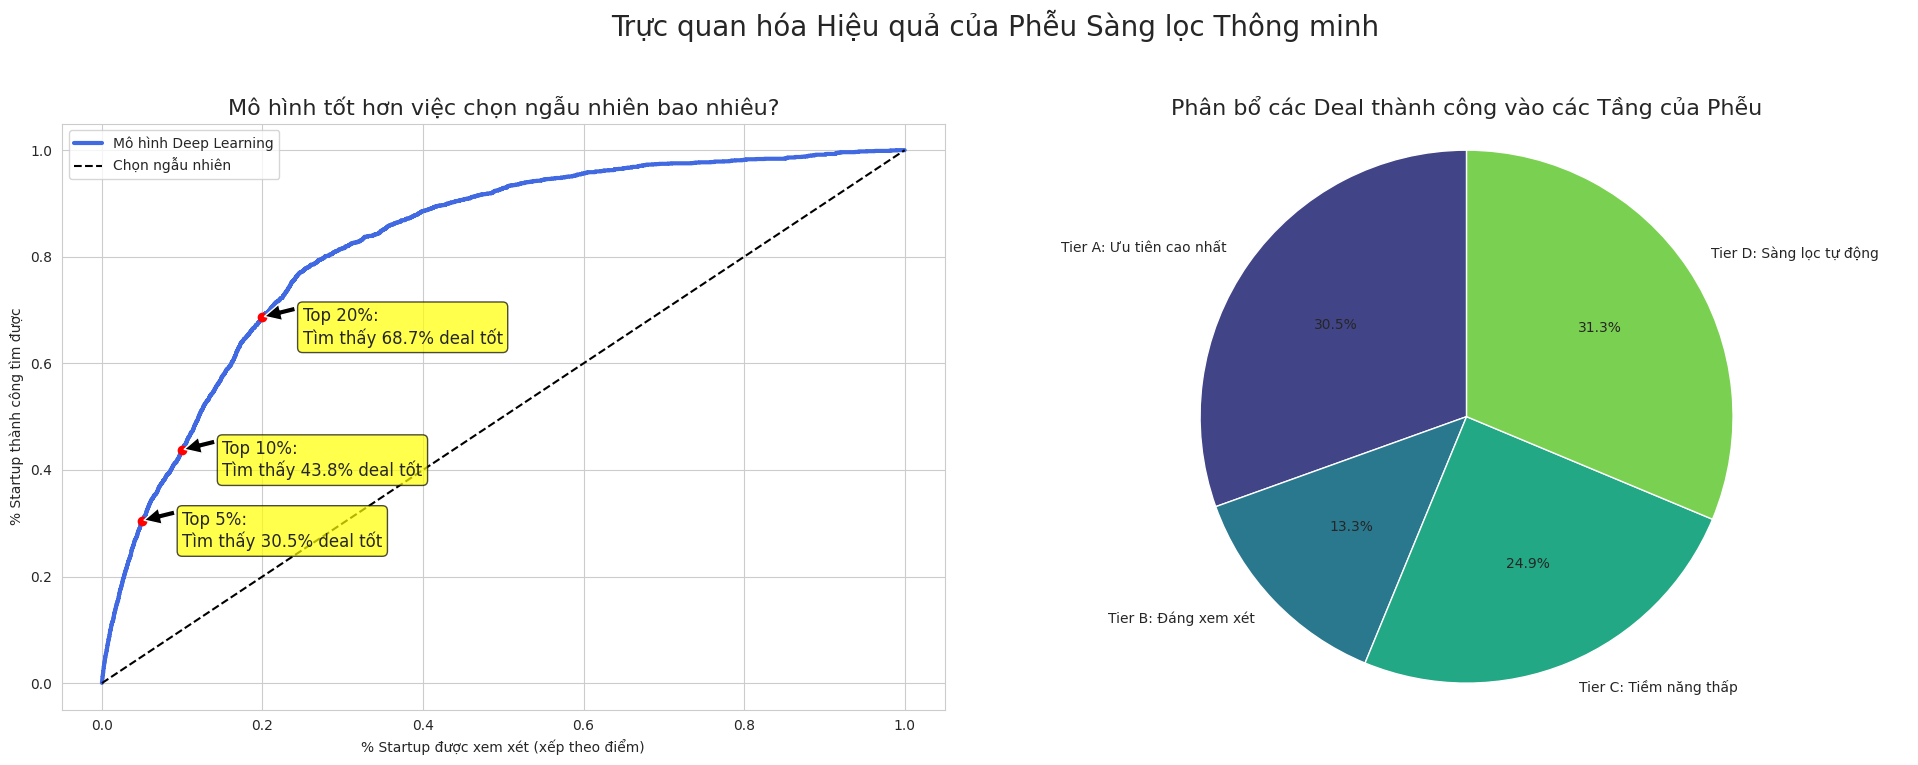

In [ ]:
# 4. Trực quan hóa Phễu Sàng lọc
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Trực quan hóa Hiệu quả của Phễu Sàng lọc Thông minh', fontsize=20)

# Biểu đồ 1: Cumulative Gains Chart (Biểu đồ Lợi ích Tích lũy)
# Tính toán các cột cần thiết
df_eval['cumulative_success'] = df_eval['y_true'].cumsum()
df_eval['percentage_of_data'] = (df_eval.index + 1) / len(df_eval)
df_eval['percentage_of_success'] = df_eval['cumulative_success'] / total_successes

ax1.plot(df_eval['percentage_of_data'], df_eval['percentage_of_success'], label='Mô hình Deep Learning', lw=3, color='royalblue')
ax1.plot([0, 1], [0, 1], 'k--', label='Chọn ngẫu nhiên')

# Đánh dấu các điểm quan trọng
for k_percent in [0.05, 0.10, 0.20]:
    recall_at_k = df_eval.loc[int(total_startups * k_percent) - 1, 'percentage_of_success']
    ax1.plot(k_percent, recall_at_k, 'ro')
    ax1.annotate(f'Top {k_percent:.0%}:\nTìm thấy {recall_at_k:.1%} deal tốt',
                 xy=(k_percent, recall_at_k),
                 xytext=(k_percent + 0.05, recall_at_k - 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.7))

ax1.set_title('Mô hình tốt hơn việc chọn ngẫu nhiên bao nhiêu?', fontsize=16)
ax1.set_xlabel('% Startup được xem xét (xếp theo điểm)')
ax1.set_ylabel('% Startup thành công tìm được')
ax1.legend()
ax1.grid(True)



## ***6.2. Ý tưởng 2: Báo cáo Tóm tắt Đầu tư Tự động***

In [ ]:
industry_benchmarks = df_model.groupby('category_code').agg({
    'company_age_years': 'median',
    'total_funding_usd': 'median',
    'num_funding_rounds': 'median',
    'funding_velocity_usd_per_year': 'median',
    'num_milestones': 'median',
    'team_size': 'median'
}).rename(columns=lambda x: x + '_median')

In [ ]:
# Xây dựng hàm tạo báo cáo nâng cao
def generate_investment_memo_v2(startup_idx, df_model, df_eval, benchmarks):
    """
    Tạo ra một bản tóm tắt đầu tư chi tiết cho một startup cụ thể.
    """

    # Lấy thông tin cơ bản
    try:
        score = df_eval[df_eval['startup_index'] == startup_idx]['potential_score'].iloc[0]
        startup_data = df_model.loc[startup_idx]
        category = startup_data['category_code']
        benchmark_data = benchmarks.loc[category]
    except (IndexError, KeyError):
        print(f"Lỗi: Không tìm thấy thông tin cho startup index {startup_idx}.")
        return

    # Phân tích và tạo cờ
    green_flags = []
    red_flags = []

    # So sánh Vận tốc gọi vốn
    if startup_data['funding_velocity_usd_per_year'] > benchmark_data['funding_velocity_usd_per_year_median'] * 1.5:
        green_flags.append(f"Vận tốc gọi vốn (${startup_data['funding_velocity_usd_per_year']:,.0f}/năm) vượt trội so với trung vị ngành (${benchmark_data['funding_velocity_usd_per_year_median']:,.0f}/năm).")

    # So sánh Tổng vốn
    if startup_data['total_funding_usd'] > benchmark_data['total_funding_usd_median'] * 2.0:
        green_flags.append(f"Tổng vốn gọi được (${startup_data['total_funding_usd']:,.0f}) cao hơn đáng kể so với trung vị ngành (${benchmark_data['total_funding_usd_median']:,.0f}).")

    # So sánh Số cột mốc
    if startup_data['num_milestones'] > benchmark_data['num_milestones_median']:
        green_flags.append(f"Số cột mốc ({int(startup_data['num_milestones'])}) cao hơn trung vị ngành ({int(benchmark_data['num_milestones_median'])}).")

    # Kiểm tra các dấu hiệu rủi ro
    if startup_data['time_since_last_funding'] > 3.0 and startup_data['num_funding_rounds'] > 0:
        red_flags.append(f"Đã {startup_data['time_since_last_funding']:.1f} năm kể từ lần gọi vốn cuối. Có thể đang gặp khó khăn trong việc gọi vốn tiếp theo (Bridge round?).")

    if startup_data['num_funding_rounds'] == 0 and startup_data['company_age_years'] > 4.0:
        red_flags.append(f"Công ty đã {startup_data['company_age_years']:.1f} tuổi nhưng chưa từng gọi vốn. Cần làm rõ mô hình kinh doanh (bootstrapping?).")

    # Tạo báo cáo
    print("="*70)
    print(f"BÁO CÁO TÓM TẮT ĐẦU TƯ - STARTUP INDEX: {startup_idx}")
    print("="*70)
    print(f"ĐIỂM TIỀM NĂNG THEO MÔ HÌNH: {score:.2%}\n")

    print("--- THÔNG TIN CƠ BẢN ---")
    print(f"- Ngành: {category}")
    print(f"- Tuổi đời công ty: {startup_data['company_age_years']:.1f} năm (Trung vị ngành: {benchmark_data['company_age_years_median']:.1f} năm)")
    print(f"- Tổng vốn đã gọi: ${startup_data['total_funding_usd']:,.0f} (Trung vị ngành: ${benchmark_data['total_funding_usd_median']:,.0f})")
    print(f"- Số vòng gọi vốn: {int(startup_data['num_funding_rounds'])}")
    print(f"- Số cột mốc: {int(startup_data['num_milestones'])}")

    print("\n--- PHÂN TÍCH TỰ ĐỘNG ---")
    print("✅ CỜ XANH (Dấu hiệu tích cực):")

    if green_flags:
        for flag in green_flags:
            print(f"  - {flag}")
    else:
        print("  - Chưa ghi nhận dấu hiệu tích cực vượt trội so với ngành.")

    print("\n❌ CỜ ĐỎ (Dấu hiệu cần lưu ý):")

    if red_flags:
        for flag in red_flags:
            print(f"  - {flag}")
    else:
        print("  - Chưa ghi nhận dấu hiệu rủi ro rõ ràng.")

    print("\n--- GỢI Ý CÁC CÂU HỎI THẨM ĐỊNH ---")
    print("- Đội ngũ sáng lập có kinh nghiệm gì liên quan đến ngành này?")
    print("- Product-market fit đã được chứng minh như thế nào? Các chỉ số traction chính là gì?")

    if red_flags:
        print("- (Dựa trên Cờ Đỏ) Tại sao công ty đã một thời gian dài chưa gọi vốn? Kế hoạch tài chính sắp tới là gì?")

    if green_flags:
        print("- (Dựa trên Cờ Xanh) Điều gì đã giúp công ty đạt được các cột mốc/vận tốc gọi vốn ấn tượng như vậy?")

    print("="*70)


In [ ]:
# Tạo báo cáo cho các startup có điểm cao nhất trong tập test

print("\nĐang tạo báo cáo cho các startup có điểm tiềm năng cao nhất...")

top_5_indices = df_eval.head(5)['startup_index'].values

for idx in top_5_indices:
    generate_investment_memo_v2(idx, df_model, df_eval, industry_benchmarks)


Đang tạo báo cáo cho các startup có điểm tiềm năng cao nhất...
BÁO CÁO TÓM TẮT ĐẦU TƯ - STARTUP INDEX: 26099
ĐIỂM TIỀM NĂNG THEO MÔ HÌNH: 96.06%

--- THÔNG TIN CƠ BẢN ---
- Ngành: hardware
- Tuổi đời công ty: 37.7 năm (Trung vị ngành: 5.0 năm)
- Tổng vốn đã gọi: $0 (Trung vị ngành: $0)
- Số vòng gọi vốn: 0
- Số cột mốc: 16

--- PHÂN TÍCH TỰ ĐỘNG ---
✅ CỜ XANH (Dấu hiệu tích cực):
  - Số cột mốc (16) cao hơn trung vị ngành (0).

❌ CỜ ĐỎ (Dấu hiệu cần lưu ý):
  - Công ty đã 37.7 tuổi nhưng chưa từng gọi vốn. Cần làm rõ mô hình kinh doanh (bootstrapping?).

--- GỢI Ý CÁC CÂU HỎI THẨM ĐỊNH ---
- Đội ngũ sáng lập có kinh nghiệm gì liên quan đến ngành này?
- Product-market fit đã được chứng minh như thế nào? Các chỉ số traction chính là gì?
- (Dựa trên Cờ Đỏ) Tại sao công ty đã một thời gian dài chưa gọi vốn? Kế hoạch tài chính sắp tới là gì?
- (Dựa trên Cờ Xanh) Điều gì đã giúp công ty đạt được các cột mốc/vận tốc gọi vốn ấn tượng như vậy?
BÁO CÁO TÓM TẮT ĐẦU TƯ - STARTUP INDEX: 184684
ĐIỂ

## ***6.3. Ý tưởng 3: Phân tích Chiến lược Ngành từ Embedding***

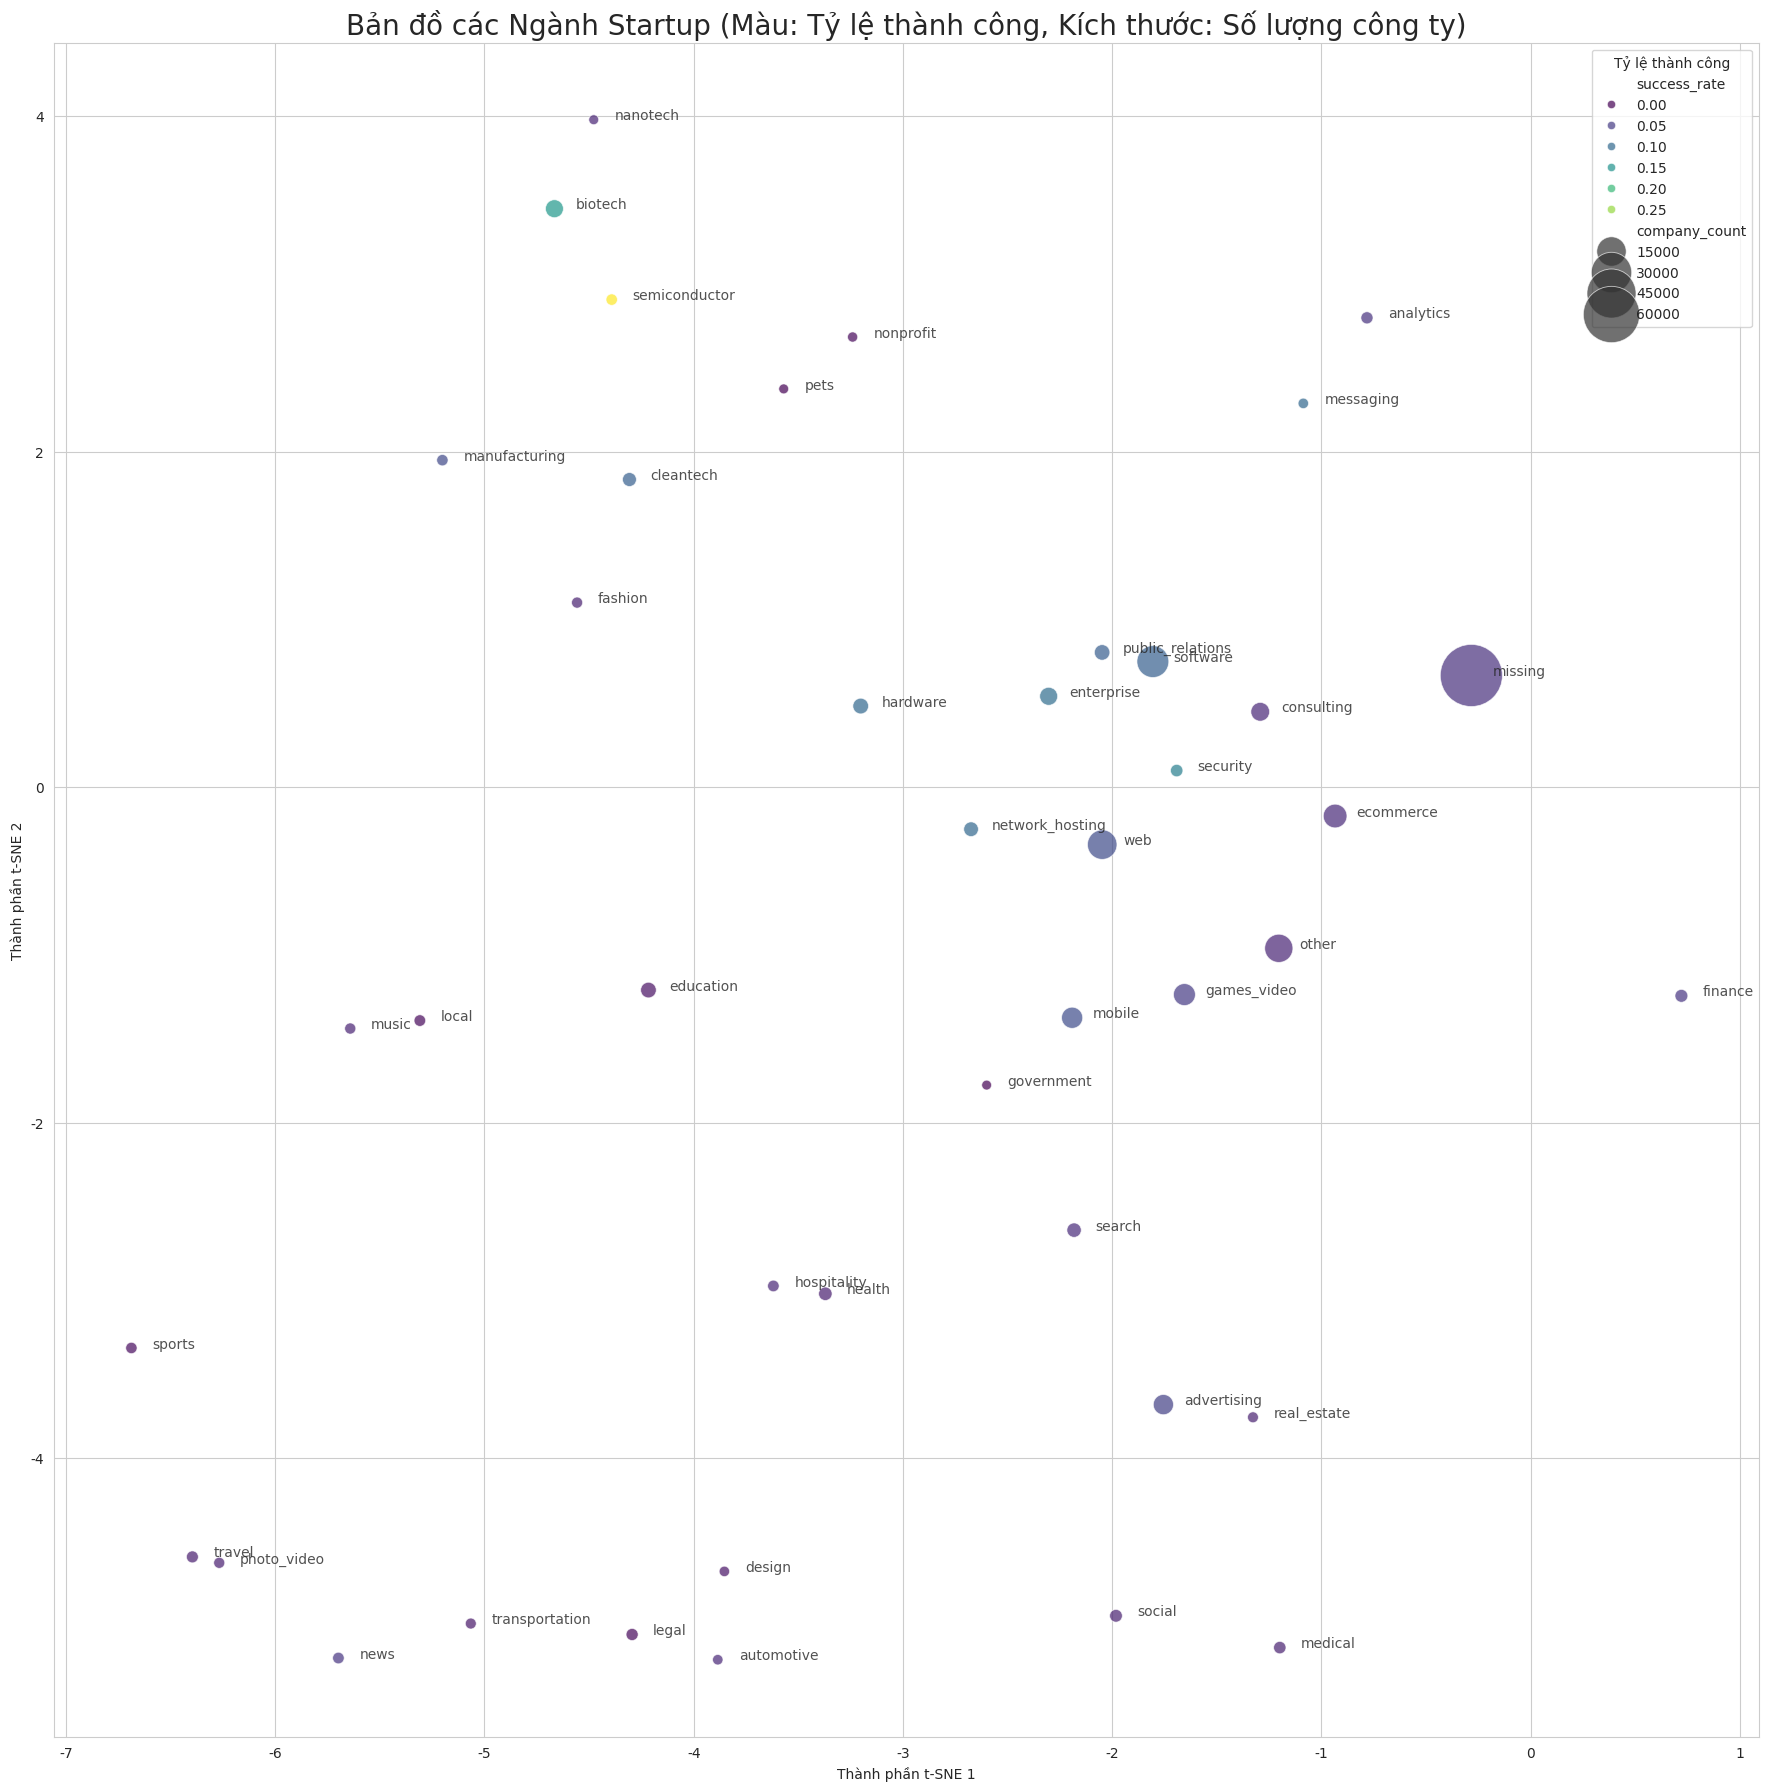

In [ ]:
embedding_weights = model.get_layer('category_embedding').get_weights()[0]

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')

embedding_2d = tsne.fit_transform(embedding_weights)

df_embedding = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df_embedding['category'] = encoder.classes_

category_success = df_model.groupby('category_code')['is_successful'].agg(['mean', 'count']).rename(columns={'mean': 'success_rate', 'count': 'company_count'})

df_embedding = df_embedding.merge(category_success.reset_index(), left_on='category', right_on='category_code', how='left').drop(columns=['category_code'])
df_embedding.fillna(0, inplace=True)

plt.figure(figsize=(22, 22))

sns.scatterplot(data=df_embedding, x='x', y='y', hue='success_rate', size='company_count', sizes=(50, 2000), palette='viridis', alpha=0.7)

for i, row in df_embedding.iterrows():
    plt.text(row['x']+0.1, row['y'], row['category'], fontsize=10, alpha=0.8)

plt.title('Bản đồ các Ngành Startup (Màu: Tỷ lệ thành công, Kích thước: Số lượng công ty)', fontsize=20)
plt.xlabel('Thành phần t-SNE 1')
plt.ylabel('Thành phần t-SNE 2')
plt.legend(title='Tỷ lệ thành công', loc='best')
plt.grid(True)
plt.show()